In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from sklearn.model_selection import train_test_split
from torch import nn
import torch.nn.functional as F
from scipy.stats import linregress
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
from sklearn.manifold import TSNE
import json

In [2]:
def moving_average(data, window_size=15):
    X_smooth = np.zeros(data.shape)
    for i,channel in enumerate(data):
        X_smooth[i] = np.convolve(channel, np.ones(window_size)/window_size, mode='same')
    return torch.from_numpy(X_smooth).to(torch.float32)
def warp_time(data, label, max_scale=1.5):
    data = data.numpy()

    L = data.shape[1]
    scale = np.random.uniform(1, max_scale)
    new_L = int(L * scale)
    orig_t = np.linspace(0, 1, L)
    new_t = np.linspace(0, 1, new_L)

    warped = np.zeros((data.shape[0], new_L))
    for i, channel in enumerate(data):
        warped[i] = np.interp(new_t, orig_t, channel)
    
    label = torch.from_numpy(np.interp(new_t, orig_t, label)).to(torch.float32)
    # label = label * scale

    # randomly crop to original length
    if new_L > L:
        start_idx = np.random.randint(0, new_L - L)
        warped = warped[:, start_idx:start_idx + L]
        label = label[start_idx:start_idx + L]
        # label = label - (start_idx / L)

    return torch.from_numpy(warped).to(torch.float32), label
def segment_y(y, t=40):
    end_rep_markers = torch.where(torch.diff(y) < 0)[0]
    y = torch.zeros_like(y)
    starts = (end_rep_markers - t).clamp(0)
    ends = (end_rep_markers + t).clamp(0, y.shape[0])
    for start,end in zip(starts, ends):
        y[start: end] = 1
    return y
class IMUDataset(Dataset):
    def __init__(self, df, winsize=250, stride=50, transform=None, aug=False):
        self.X = torch.from_numpy(df[['acc_x', 'acc_y', 'acc_z', 'gyr_x', 'gyr_y', 'gyr_z']].values)
        self.y = torch.from_numpy(df['rir'].values).to(torch.float32)
        if transform is not None:
            self.X = transform(self.X)
        self.X = self.X.transpose(0, 1).to(torch.float32)
        self.winsize = winsize
        self.stride = stride
        self.len = (self.X.shape[1] - winsize) // stride + 1
        self.aug = aug
    def __len__(self):
        return self.len
    def __getitem__(self, i):
        start = i * self.stride
        end = start + self.winsize
        y = self.y[start:end]#.mean()

        # FOR REGRESSION: y = y.mean() (single value)
        y = y.mean()

        # FOR BINARY: 1 if y is last rep (< 1.5), 0 if not (single value)
        # y = torch.Tensor([1.0 if y.mean() < 1.5 else 0.0])

        # FOR SEGMENTATION: if y changes during window, y = 1 at that point. everywhere else is 0 (<winsize> values)
        # y = segment_y(y)

        # FOR SEGMENTATION REGRESSION: y = time when y changes (single value)
        # diff = torch.diff(y)
        # y = torch.diff(y).argmin().unsqueeze(0) / self.winsize if diff.min() < 0 else torch.Tensor([-1])
        
        X = self.X[:, start:end]
        X = moving_average(X)
        return X, y

In [3]:
HZ = 100
in_channels = 6
df = pd.read_csv('../data/data.csv')
session_ids = df['session_id'].unique()
print(len(session_ids))
train_ids, val_ids = train_test_split(session_ids, test_size=0.2, random_state=42)

df[['acc_x', 'acc_y', 'acc_z']] = (df[['acc_x', 'acc_y', 'acc_z']] / 2.0).clip(-1, 1)           # normalize accelerometer data from [-2g, 2g] to [-1, 1]
df[['gyr_x', 'gyr_y', 'gyr_z']] = (df[['gyr_x', 'gyr_y', 'gyr_z']] / 250.0).clip(-1, 1)         # normalize gyroscope data from [-250dps, 250dps] to [-1, 1]

# winsize_t = 5 # seconds
# stride_t = 0.01 # seconds
# winsize = int(winsize_t * HZ)
# stride = int(stride_t * HZ)
winsize = 256
stride = 2
print(winsize, stride)

train = df.loc[df['session_id'].isin(train_ids), ['acc_x', 'acc_y', 'acc_z', 'gyr_x', 'gyr_y', 'gyr_z']].values
# norm = torch.from_numpy(train.mean(axis=0)), torch.from_numpy(train.std(axis=0))

# def transform(x):
    # return (x - norm[0]) / norm[1]
transform = None

train_dataset = ConcatDataset([IMUDataset(df[df['session_id'] == session_id], winsize, stride, transform, aug=True) for session_id in train_ids])
val_dataset = ConcatDataset([IMUDataset(df[df['session_id'] == session_id], winsize, stride, transform, aug=False) for session_id in val_ids])

len(train_dataset), len(val_dataset)

72
256 2


(94665, 24819)

In [4]:
class ResBlock(nn.Module):
    # One layer of convolutional block with batchnorm, relu and dropout
    def __init__(
            self, in_channels, out_channels,
            kernel_size=3, stride=1, dropout=0.0,
        ):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv1d(
                in_channels, out_channels, 
                kernel_size=kernel_size, stride=stride, padding=kernel_size // 2,
            ),
            nn.BatchNorm1d(out_channels),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        self.skip = nn.Conv1d(
            in_channels, out_channels, kernel_size=1, stride=stride
        ) if in_channels != out_channels or stride > 1 else nn.Identity()
    def forward(self, x):
        return self.block(x) + self.skip(x)

class DepthBlock(nn.Module):
    # "depth" number of ConvBlocks with downsample on the first block
    def __init__(
            self, depth, in_channels, out_channels,
            kernel_size=3, downsample_stride=2, 
            dropout=0.0
    ):
        super().__init__()
        self.blocks = nn.Sequential(*[
            ResBlock(
                in_channels=in_channels if i == 0 else out_channels, 
                out_channels=out_channels,
                kernel_size=kernel_size, 
                stride=downsample_stride if i == 0 else 1,
                dropout=dropout
            )
            for i in range(depth)
        ])
    def forward(self, x):
        return self.blocks(x)
    
class Encoder(nn.Module):
    def __init__(self, config):
        super().__init__()

        self.width = config['width']
        self.depth = config['depth']
        self.stem_out_c = config['stem_out_c']
        self.stem_kernel = config['stem_kernel']
        self.dropout = config['dropout']

        if len(self.width) != len(self.depth):
            raise ValueError('Width and depth must have the same length')
        self.conv_out_channels = self.stem_out_c if len(self.width) == 0 else self.width[-1]

        self.encoder = nn.Sequential(
            nn.Conv1d(in_channels, self.stem_out_c, kernel_size=self.stem_kernel, padding=3),
            nn.BatchNorm1d(self.stem_out_c),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),
            *[DepthBlock(
                depth=self.depth[i],
                in_channels=self.stem_out_c if i == 0 else self.width[i-1], 
                out_channels=self.width[i],
                dropout=self.dropout, 
            ) for i in range(len(self.width))]
        )
    def forward(self, x):
        return self.encoder(x)

class AutoEncoder(nn.Module):
    def __init__(self, config):
        super().__init__()

        self.config = config

        self.encoder = Encoder(config)
        self.pool = nn.AdaptiveAvgPool1d(1)
    def forward(self, x):
        x = self.encoder(x)
        x = self.pool(x).squeeze(-1)
        return x

In [5]:
device = 'cuda'

weights,config = torch.load('../best_model-class-83.pth')
# weights = torch.load('../logs/search256/34/best_model.pth')
# config = json.load(open('../logs/search256/34/config.json'))

weights = {'.'.join(k.split('.')[1:]):v for k,v in weights.items() if k.startswith('encoder.')}

model = AutoEncoder(config)
model.encoder.load_state_dict(weights)
model.eval()

model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()
trainloader = DataLoader(train_dataset, batch_size=128, shuffle=True)
valloader = DataLoader(val_dataset, batch_size=128, shuffle=False)

# middle of window
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

739840


In [6]:
ys = []
encodings = []
with torch.no_grad():
    for X,y in valloader:
        X = X.to(device)
        encodings.append(model(X).cpu())
        ys.append(y)
ys = torch.cat(ys).numpy()
encodings = torch.cat(encodings).numpy()

In [7]:
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=42)
features_2d = tsne.fit_transform(encodings)

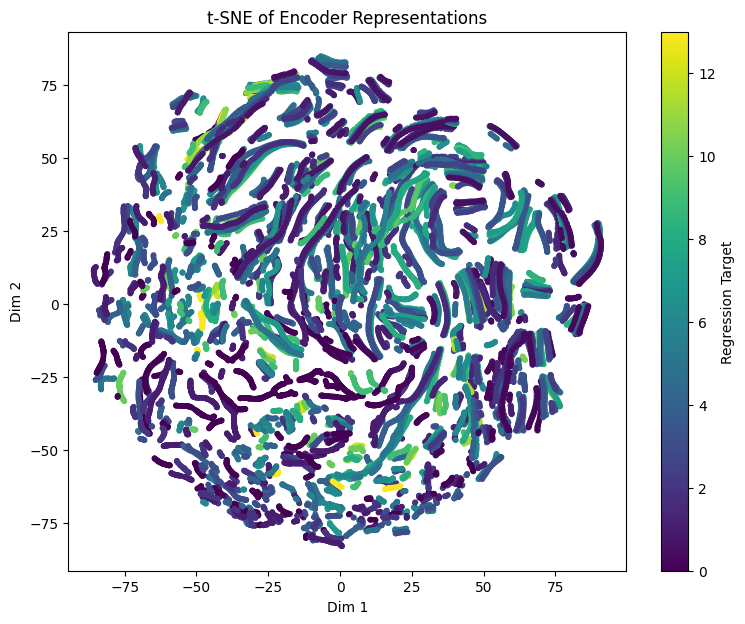

In [8]:
plt.figure(figsize=(9,7))
sc = plt.scatter(features_2d[:, 0], features_2d[:, 1], c=ys, cmap='viridis', alpha=1, s=10)
plt.colorbar(sc, label="Regression Target")

# plt.legend(*scatter.legend_elements(), title="Classes")
plt.title("t-SNE of Encoder Representations")
plt.xlabel("Dim 1")
plt.ylabel("Dim 2")
plt.show()